In [348]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

## Enhance Raw Data

#### Load dataset

In [349]:
df = pd.read_csv("../data/final_dataset_mest.csv")

#### Unify variables

For more precise modeling, all variables were standardized to a common spatial unit (km²).

In [350]:
# unifying calculations (per km^2)
df['crime_density'] = df['crime_total'] / df['area_km2']
df['crime_attractor_density'] = (df['poi_pub'] + df['poi_nightclub'] + df['poi_bar']) / df['area_km2']
df['crime_generator_density'] = (df['poi_cafe'] + df['poi_museum'] + df['poi_attraction']) / df['area_km2']
df['tourist_density'] = df['nights_non_residents'] / df['area_km2']
df['foreigner_density'] = df['foreigners'] / df['area_km2']
df['university_density'] = df['people_university'] / df['area_km2']
df['airbnb_economy_density'] = df['airbnb_economy'] / df['area_km2']

In [351]:
# handle NaN values
df = df.fillna(0.0)

# Economy vs Luxury Airbnb Density

#### Construct Simple OLS Models

1. we predict crime_density in each Prague district
2. separate so called crime attractors (bars, pubs, nightclubs) and crime generators (cafes, museums, atractions) into two separated models
3. remove variables that are most likely multicolinear with crime_density (crime_total, crime_Burglary, crime_Disorder, crime_Other, crime_Theft,...)

In [352]:
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

## Outliers

#### Analysing Outliers

In [353]:

def detect_outliers(linear_model):
    influence = linear_model.get_influence()
    n = int(linear_model.nobs)
    cooks_d = influence.cooks_distance[0]
    outliers = np.where(cooks_d > 4 / n)[0]
    return outliers, cooks_d

# outliers detection using Cook's distance
outliers_economy, cooks_d_economy = detect_outliers(lm_crime_economy)
print(f"Outliers of economy model: {outliers_economy}")

outliers_luxury, cooks_d_luxury = detect_outliers(lm_crime_luxury)
print(f"Outliers of luxury model: {outliers_luxury}")

Outliers of economy model: [ 0  2  8 11 15 19 21 46 56]
Outliers of luxury model: [ 0  2  4  8 11 15 19 21 46 56]


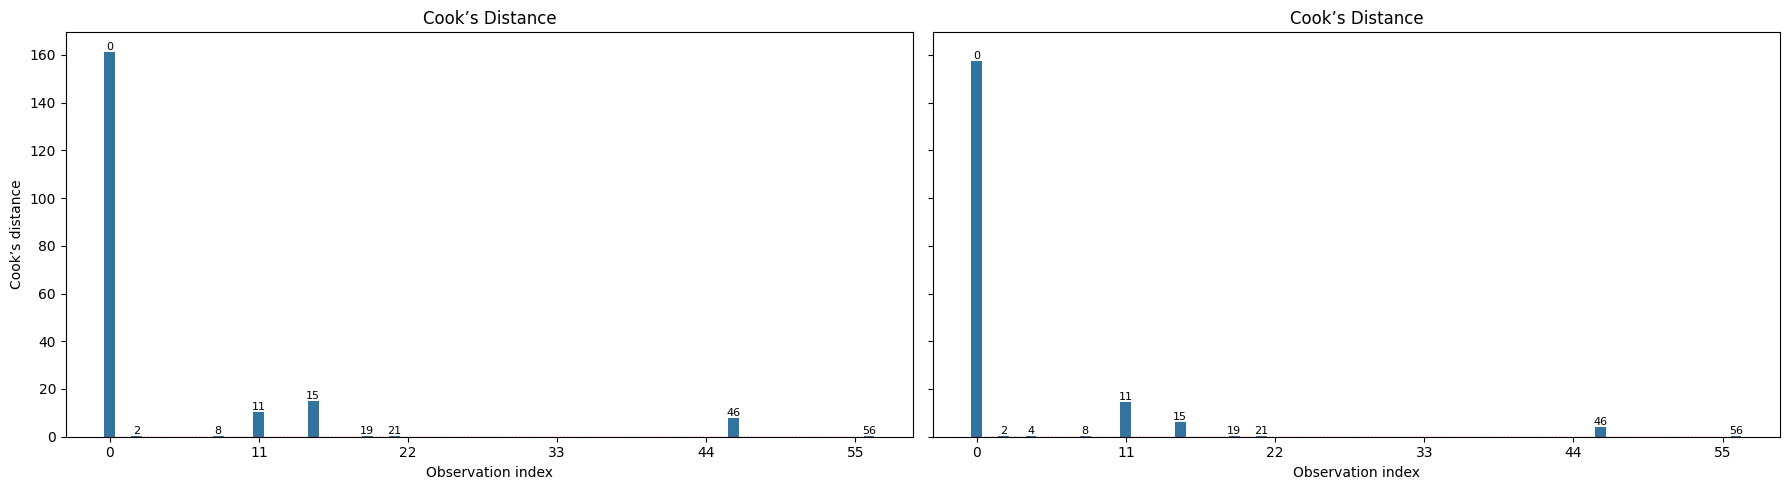

In [354]:
# plot two outliers graphs

def outliers_plot(cooks_d_1, cooks_d_2, outliers_1, outliers_2):

    def _outliers_plot(fig, axes, cooks_d, outliers, _ax=0): 
        n_econ = len(cooks_d)
        x_econ = np.arange(n_econ)
        ax = axes[_ax]
        sns.barplot(x=x_econ, y=cooks_d, ax=ax)
        ax.plot(x_econ, np.full(n_econ, 4 / n_econ), linestyle="dotted", linewidth=1, color="red")
        for o in outliers:
            ax.text(o, cooks_d[o] + 0.005, str(o), ha="center", va="bottom", fontsize=8)
        ax.set_title("Cook’s Distance")
        ax.set_xlabel("Observation index")
        ax.set_ylabel("Cook’s distance")
        ax.set_xticks(range(0, n_econ, max(1, n_econ // 5)))

    fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)
    _outliers_plot(fig, axes, cooks_d_1, outliers_1, _ax=0)
    _outliers_plot(fig, axes, cooks_d_2, outliers_2, _ax=1)
    plt.tight_layout()
    plt.show()

outliers_plot(cooks_d_economy, cooks_d_luxury, outliers_economy, outliers_luxury)

#### Removing Outliers

In [355]:
# same for the luxury and economy models
X_no_outliers_e = df.drop(outliers_economy)
X_no_outliers_l = df.drop(outliers_luxury)

In [356]:
# refit models without outliers
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_no_outliers_e).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_no_outliers_l).fit()

## Linearity and Homoscedasticity

#### Analysis of linearity and homoscedasticity quality

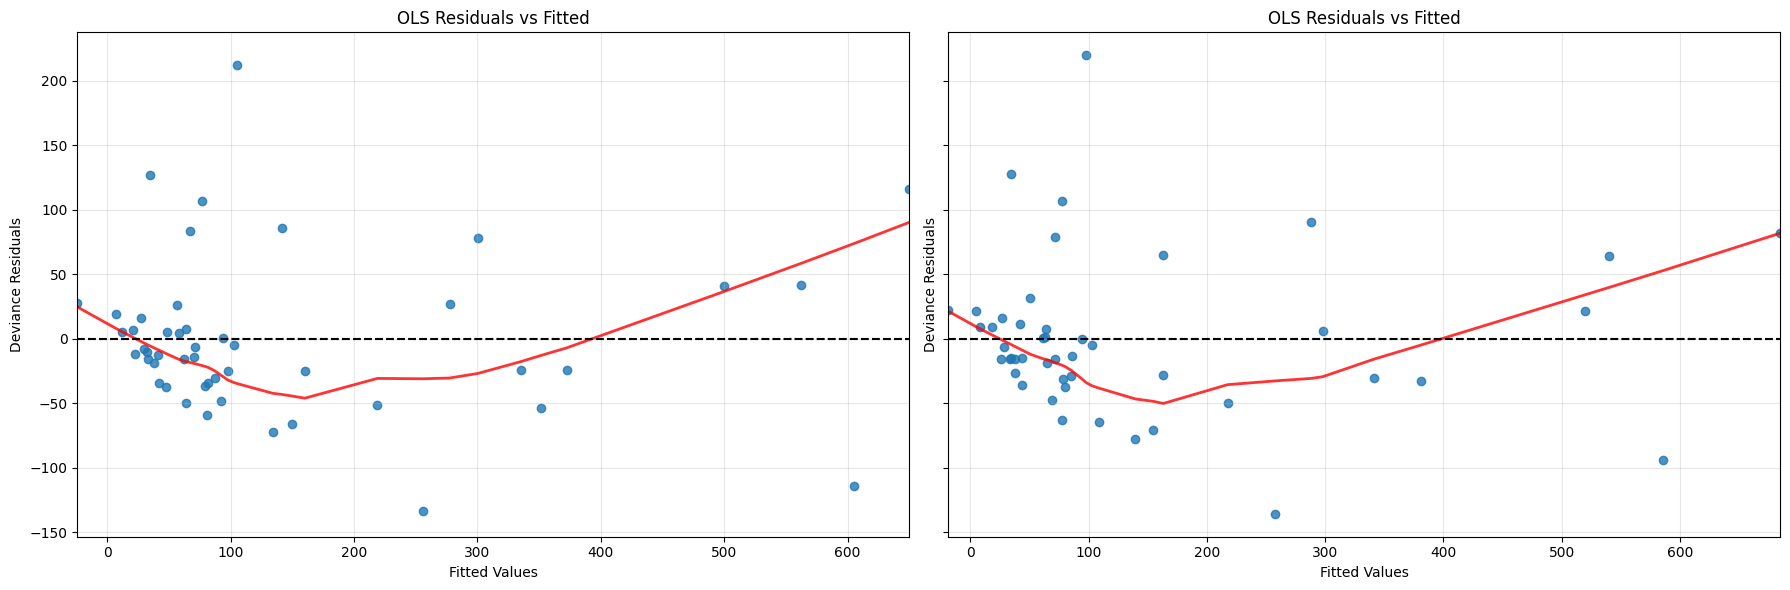

In [357]:
# plot two 'residuals vs fitted' fugures next to each other
def res_vs_fitted_ols(lm1, lm2):

    def _res_vs_fitted_plt(linear_model, _ax=0):

        fitted_econ = linear_model.fittedvalues
        resid_econ = linear_model.resid

        sns.residplot(
            x=fitted_econ,
            y=resid_econ,
            lowess=True,
            line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
            ax=axes[_ax]
        )

        axes[_ax].axhline(0, color='black', linestyle='--')
        axes[_ax].set_title('OLS Residuals vs Fitted')
        axes[_ax].set_xlabel('Fitted Values')
        axes[_ax].set_ylabel('Deviance Residuals')
        axes[_ax].grid(True, alpha=0.3)

    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _res_vs_fitted_plt(lm1, _ax=0)
    _res_vs_fitted_plt(lm2, _ax=1)

    plt.tight_layout()
    plt.show()

res_vs_fitted_ols(lm_crime_economy, lm_crime_luxury)

Residuals vs fitted plot shows significant heteroscedasticity and data is not linear. It is necessary to switch from simple OLS model to GLM model for futher data manupulation. In the next step we find proper feature transformation to reduce non-linearity and  heteroscedasticity.

#### Remove more significant outliers

In [358]:
X_no_outliers_e = X_no_outliers_e.drop([30, 34, 39])
X_no_outliers_l = X_no_outliers_l.drop([30, 34, 39])

In [359]:
formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'airbnb_economy_density + tourist_density + '
           'crime_attractor_density + crime_generator_density + '
           'foreigner_density + university_density + unemployment + mhd_density')

glm_log_economy = smf.glm(
    formula=formula, 
    data=X_no_outliers_e, 
    family=sm.families.InverseGaussian()
).fit()

print(glm_log_economy.summary())
glm_log_economy.aic


                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   45
Model:                                 GLM   Df Residuals:                       34
Model Family:              InverseGaussian   Df Model:                           10
Link Function:              InverseSquared   Scale:                        0.011811
Method:                               IRLS   Log-Likelihood:                -57.301
Date:                     Mon, 29 Dec 2025   Deviance:                      0.45968
Time:                             21:26:57   Pearson chi2:                    0.402
No. Iterations:                          7   Pseudo R-squ. (CS):             0.6795
Covariance Type:                 nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

np.float64(136.6011182697528)

In [360]:
formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'airbnb_luxury_density + tourist_density + '
           'crime_attractor_density + crime_generator_density + '
           'foreigner_density + university_density + unemployment + mhd_density')

glm_log_luxury = smf.glm(
    formula=formula, 
    data=X_no_outliers_l, 
    family=sm.families.InverseGaussian()
).fit()

print(glm_log_luxury.summary())
glm_log_luxury.aic

                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   44
Model:                                 GLM   Df Residuals:                       33
Model Family:              InverseGaussian   Df Model:                           10
Link Function:              InverseSquared   Scale:                        0.012014
Method:                               IRLS   Log-Likelihood:                -55.566
Date:                     Mon, 29 Dec 2025   Deviance:                      0.44838
Time:                             21:26:57   Pearson chi2:                    0.396
No. Iterations:                          7   Pseudo R-squ. (CS):             0.6780
Covariance Type:                 nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

np.float64(133.13136964044537)

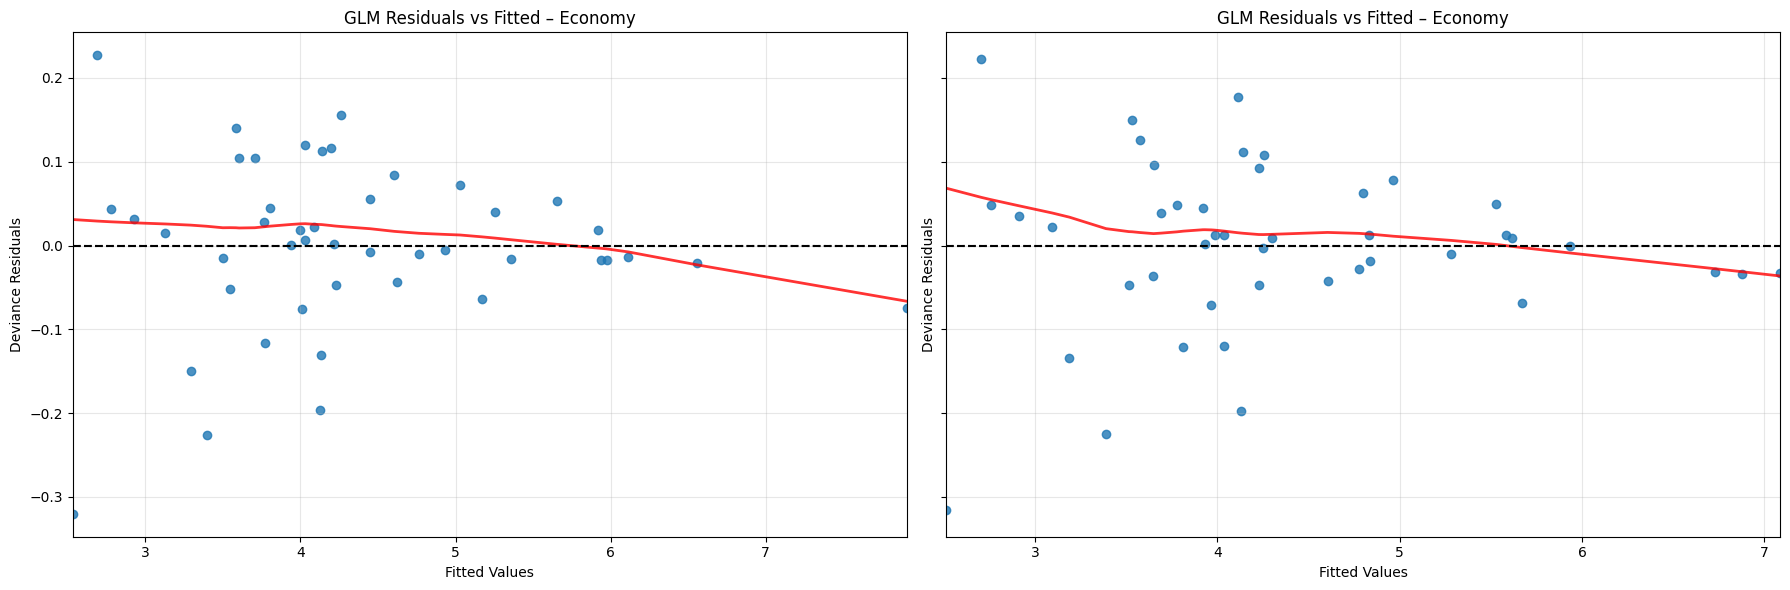

In [361]:
def res_vs_fitted_glm(glm1, glm2):
    

    def _res_vs_fitted(model_glm, _ax=0):
    
        fitted_econ = model_glm.mu
        resid_econ = model_glm.resid_deviance

        sns.residplot(
            x=fitted_econ,
            y=resid_econ,
            lowess=True,
            line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
            ax=axes[_ax]
        )

        axes[_ax].axhline(0, color='black', linestyle='--')
        axes[_ax].set_title('GLM Residuals vs Fitted – Economy')
        axes[_ax].set_xlabel('Fitted Values')
        axes[_ax].set_ylabel('Deviance Residuals')
        axes[_ax].grid(True, alpha=0.3)

    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _res_vs_fitted(glm1, _ax=0)
    _res_vs_fitted(glm2, _ax=1)

    plt.tight_layout()
    plt.show()

res_vs_fitted_glm(glm_log_economy, glm_log_luxury)

Good enough, no need to do spline or something.
Current transformation is "good enough" structurally. The remaining "wiggles" in the red line are likely noise, not a structural trend that a Spline would fix better than the current setup

In [362]:
# Homoscedasticity tests

_, pval, __, ___ = het_breuschpagan(glm_log_economy.resid_deviance, glm_log_economy.model.exog)
print(f"Breusch-Pagan p-value - economy airbnb: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_log_luxury.resid_deviance, glm_log_luxury.model.exog)
print(f"Breusch-Pagan p-value - luxury airbnb: {pval}")

Breusch-Pagan p-value - economy airbnb: 0.05574756585010101
Breusch-Pagan p-value - luxury airbnb: 0.06193469077594191


The Breusch–Pagan test shows marginal evidence of heteroscedasticity. While slightly below conventional thresholds, the residuals do not strongly violate the homoscedasticity assumption, so the model can be considered acceptable for further analysis.

## Multicollinearity and Feature Selection

#### Correlation Matrix

In [363]:
features_economy = ['dist_center_km', 'airbnb_economy_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_economy = X_no_outliers_e[features_economy].corr()

features_luxury = ['dist_center_km', 'airbnb_luxury_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_luxury = X_no_outliers_l[features_luxury].corr()

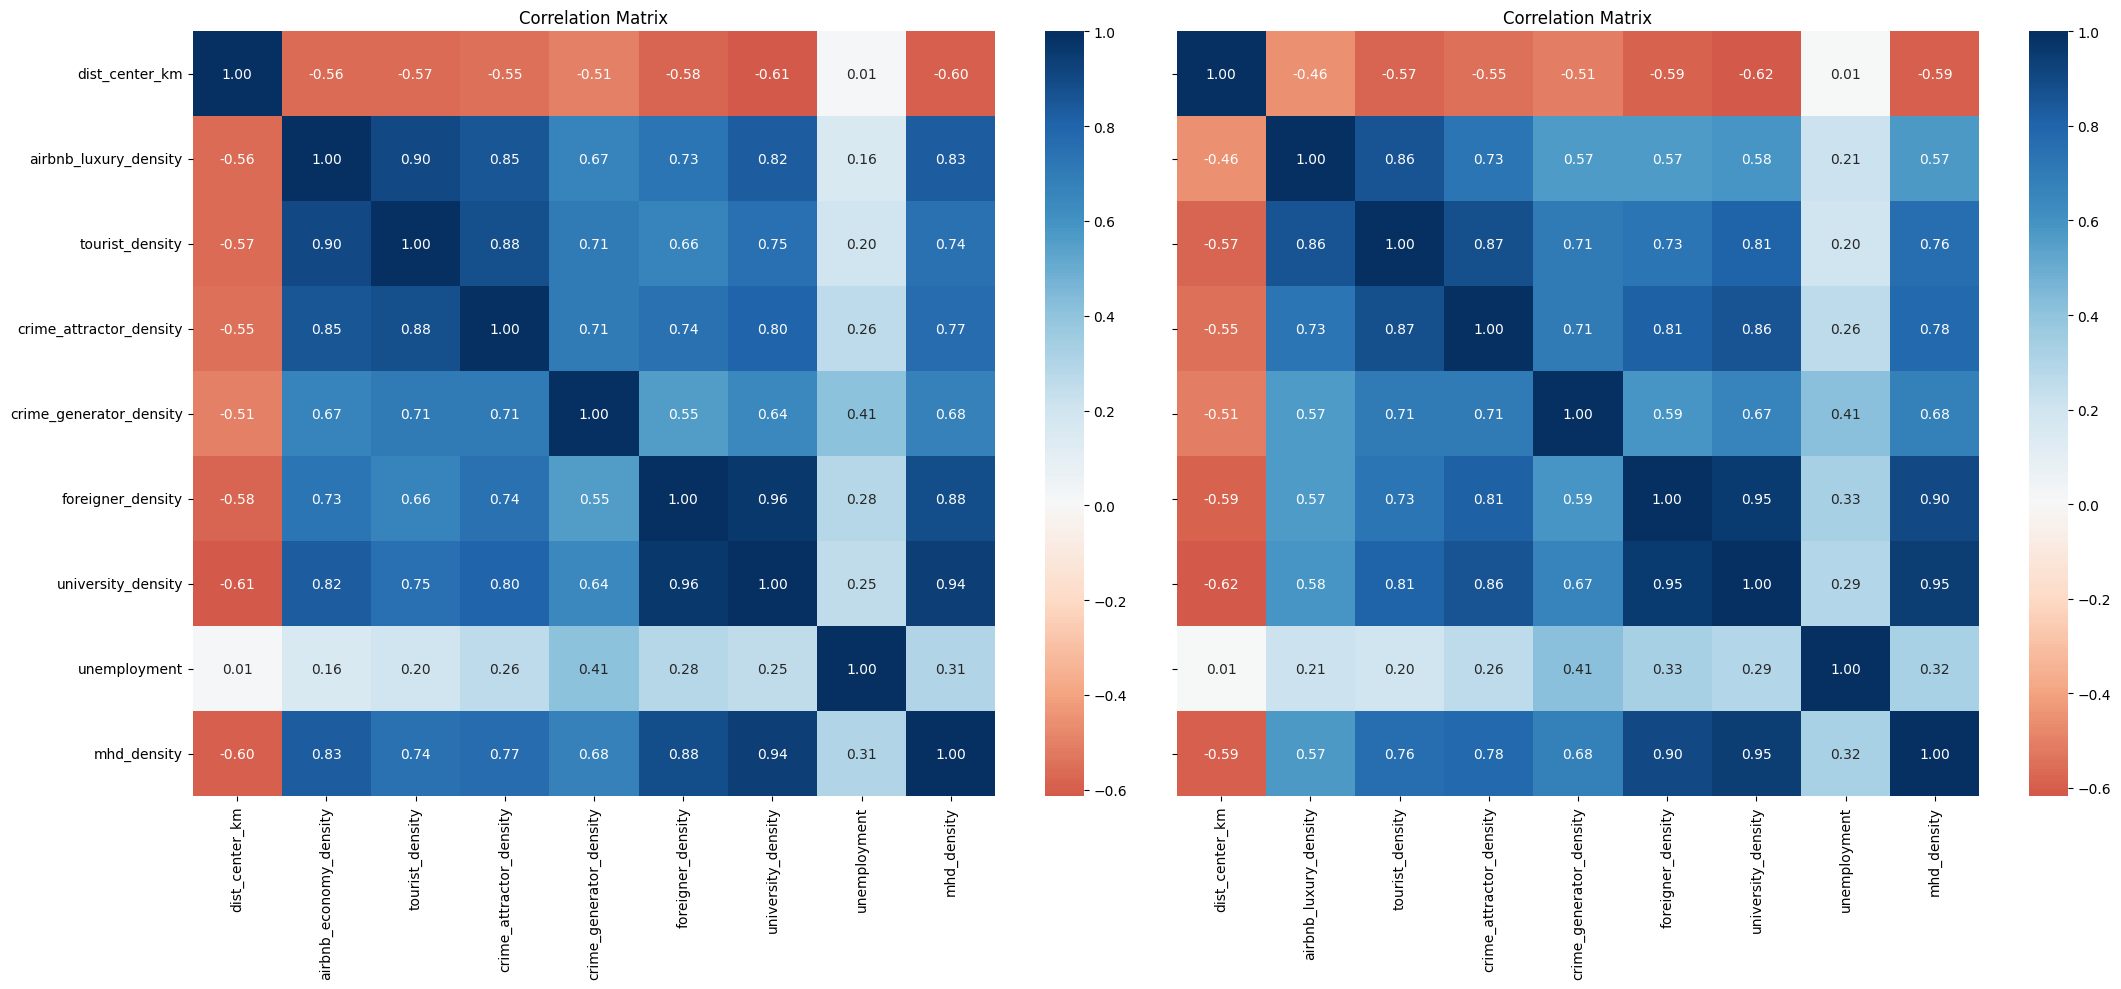

In [364]:
def corr_mtx_plt(corr_matrix_1, corr_matrix_2):

    def _corr_mtx_plt(corr_matrix, _ax=0):
        sns.heatmap(
            corr_matrix,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt=".2f",
            ax=axes[_ax]
        )
        axes[_ax].set_title("Correlation Matrix")

    _, axes = plt.subplots(1, 2, figsize=(22, 10), sharey=True)

    _corr_mtx_plt(corr_matrix_1, _ax=0)
    _corr_mtx_plt(corr_matrix_2, _ax=1)

    plt.tight_layout()
    plt.show()

corr_mtx_plt(corr_matrix_economy, corr_matrix_luxury)

For a value n of the correlation matrix:
- 0.1 ≤ n < 0.3 → weak positive correlation
- 0.3 ≤ n < 0.5 → moderate positive correlation
- n ≥ 0.5 → strong positive correlation
- –0.3 < n ≤ –0.1 → weak negative correlation
- –0.5 < n ≤ –0.3 → moderate negative correlation
- n ≤ –0.5 → strong negative correlation

Except the variable 'unemployment', which correlates weakly with every other variable, the rest shows strong positive or negative correlation.
Thus, feature selection is critical. There are no significant differences between the matrices of the economy and luxury airbnb.

#### VIF Factor

In [365]:
# economy
X_vif_economy = X_no_outliers_e[features_economy].copy()
X_vif_economy['intercept'] = 1

vif_data_economy = pd.DataFrame()
vif_data_economy["feature"] = X_vif_economy.columns
vif_data_economy["VIF"] = [variance_inflation_factor(X_vif_economy.values, i) for i in range(len(X_vif_economy.columns))]

# luxury
X_vif_luxury = X_no_outliers_l[features_luxury].copy()
X_vif_luxury['intercept'] = 1

vif_data_luxury = pd.DataFrame()
vif_data_luxury["feature"] = X_vif_luxury.columns
vif_data_luxury["VIF"] = [variance_inflation_factor(X_vif_luxury.values, i) for i in range(len(X_vif_luxury.columns))]


In [366]:
print("\nEconomy Airbnb VIFs:\n")
print(vif_data_economy.sort_values(by="VIF", ascending=False))

print("\nLuxury Airbnb VIFs:\n")
print(vif_data_luxury.sort_values(by="VIF", ascending=False))


Economy Airbnb VIFs:

                   feature        VIF
9                intercept  39.329337
6       university_density  28.996173
5        foreigner_density  15.117340
8              mhd_density  10.214547
1   airbnb_economy_density   8.308187
2          tourist_density   7.716321
3  crime_attractor_density   5.790172
4  crime_generator_density   2.875791
0           dist_center_km   1.914470
7             unemployment   1.569770

Luxury Airbnb VIFs:

                   feature        VIF
9                intercept  38.772322
6       university_density  38.681807
5        foreigner_density  15.424207
2          tourist_density  12.916764
8              mhd_density  11.956914
3  crime_attractor_density   6.888568
1    airbnb_luxury_density   5.887529
4  crime_generator_density   2.996390
0           dist_center_km   1.907548
7             unemployment   1.558655


For a VIF value n:
- ≈ 1 → no multicollinearity
- 1 – 2 → very low
- 2 – 5 → moderate (still acceptable)
- 5 – 10 → high (needs examination)
- \> 10 → severe

The VIF analysis indicates that unemployment, consistent with the correlation matrix results, dist_center_km, and crime_generator_density have acceptable multicollinearity levels, however, according to the correlation matrix they are already in the grey zone. The remaining variables exhibit high VIF values, suggesting problematic multicollinearity. Therefore, feature selection is employed in the next step to address this issue.

### Removing multicollinearity

##### Stepwise Dropping Features

In [ ]:
def stepwise_feature_selection(df, list_of_features, threshold=5.0):
    """
    Automatically drops the variable with the highest VIF 
    until all remaining variables are below the threshold.
    """
    while True:

        X = df[list_of_features].copy()
        X['intercept'] = 1
        
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        vif = vif[vif['feature'] != 'intercept'].sort_values('VIF', ascending=False)
        
        max_vif = vif.iloc[0]['VIF']
        if max_vif > threshold:
            if vif.iloc[0]['feature'] == 'airbnb_economy_density':
                target = vif.iloc[1]['feature']
            else:
                target = vif.iloc[0]['feature']
                
            print(f"Dropping {target} with VIF {max_vif:.2f}")
            list_of_features.remove(target)
        else:
            break
            
    return list_of_features, vif


In [370]:
print(len(features_economy))
print(len(features_luxury))

_features_economy = features_economy.copy()
_features_luxury = features_luxury.copy()

# Run the selection
final_features_economy, final_vif_table_economy = stepwise_feature_selection(X_no_outliers_e, _features_economy)
print("\nFinal VIF Table:\n", final_vif_table_economy)
print()

final_features_luxury, final_vif_table_luxury = stepwise_feature_selection(X_no_outliers_l, _features_luxury)
print("\nFinal VIF Table:\n", final_vif_table_luxury)

print(len(features_economy))
print(len(features_luxury))

9
9


AttributeError: 'DataFrame' object has no attribute 'deepcopy'

##### Ridge Regression

- Predictors are measured in different units and scales

- Ridge and Lasso apply a penalty based on coefficient magnitude

- Without standardization, variables with large numeric scales are penalized more heavily, regardless of their true importance

- Standardization ensures that the regularization penalty is applied equally across predictors, making coefficient shrinkage comparable and meaningful

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_data(data, features):
    X = data[features]
    y = np.log1p(data['crime_density'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

X_scaled_econ, y_econ = scale_data(X_no_outliers_e, features_economy)
X_scaled_lux, y_lux = scale_data(X_no_outliers_l, features_luxury)

In [ ]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV

ridge_model_econ = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model_econ.fit(X_scaled_econ, y_econ)

# Create a summary of coefficients
ridge_coefs = pd.Series(ridge_model_econ.coef_, index=features_economy).sort_values(ascending=False)
print("Best Alpha for Ridge:", ridge_model_econ.alpha_)
print("\nRidge Coefficients:\n", ridge_coefs)
print()

#-------------------------------------------------------------------------------------------------

ridge_model_lux = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_model_lux.fit(X_scaled_lux, y_lux)

# Create a summary of coefficients
ridge_coefs = pd.Series(ridge_model_lux.coef_, index=features_luxury).sort_values(ascending=False)
print("Best Alpha for Ridge:", ridge_model_lux.alpha_)
print("\nRidge Coefficients:\n", ridge_coefs)

Best Alpha for Ridge: 10.0

Ridge Coefficients:
 foreigner_density          0.525183
crime_generator_density    0.157945
airbnb_economy_density     0.111552
crime_attractor_density   -0.052230
unemployment              -0.054007
dist_center_km            -0.266159
dtype: float64

Best Alpha for Ridge: 1.0

Ridge Coefficients:
 mhd_density                0.923115
airbnb_luxury_density      0.070690
crime_generator_density    0.050517
unemployment              -0.100991
crime_attractor_density   -0.243354
dist_center_km            -0.257395
dtype: float64


##### Lasso Regression

In [ ]:
lasso_model_econ = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_model_econ.fit(X_scaled_econ, y_econ)

lasso_coefs_econ = pd.Series(lasso_model_econ.coef_, index=features_economy).sort_values(ascending=False)
print("Best Alpha for Lasso:", lasso_model_econ.alpha_)
print("\nLasso Coefficients (Variables at 0 are excluded):\n", lasso_coefs_econ)

lasso_model_lux = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_model_lux.fit(X_scaled_lux, y_lux)

lasso_coefs_lux = pd.Series(lasso_model_lux.coef_, index=features_luxury).sort_values(ascending=False)
print("Best Alpha for Lasso:", lasso_model_lux.alpha_)
print("\nLasso Coefficients (Variables at 0 are excluded):\n", lasso_coefs_lux)

Best Alpha for Lasso: 0.02782411836951141

Lasso Coefficients (Variables at 0 are excluded):
 foreigner_density          0.727882
crime_generator_density    0.161665
airbnb_economy_density     0.000000
unemployment              -0.071083
crime_attractor_density   -0.086464
dist_center_km            -0.259617
dtype: float64
Best Alpha for Lasso: 0.0066937980569234876

Lasso Coefficients (Variables at 0 are excluded):
 mhd_density                0.967072
airbnb_luxury_density      0.061302
crime_generator_density    0.027584
unemployment              -0.097418
dist_center_km            -0.250329
crime_attractor_density   -0.250564
dtype: float64


/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


No significant difference between economy and luxury airbnb density in the areas was proven.

In [ ]:
# TODO: clustering
# TODO: dimensionality reduction